In [2]:
# !pip install tensorflow==2.12.0

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 9.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.33
    Uninstalling jaxlib-0.4.33:
      Successfully uninstalled jaxlib-0.4.33
  Attempting uninstall: jax
    Found existing installation: jax 0.4.33
    Uninstalling jax-0.4.33:
      Successfully uninstalled jax-0.4.33
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.12.1
    Uninsta

# Word Detection

## Median Filtering

Image is RGB, converting to grayscale.


<ipython-input-1-77be575cb3cd>:21: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  median_filtered_image = median(gray_img, square(3))


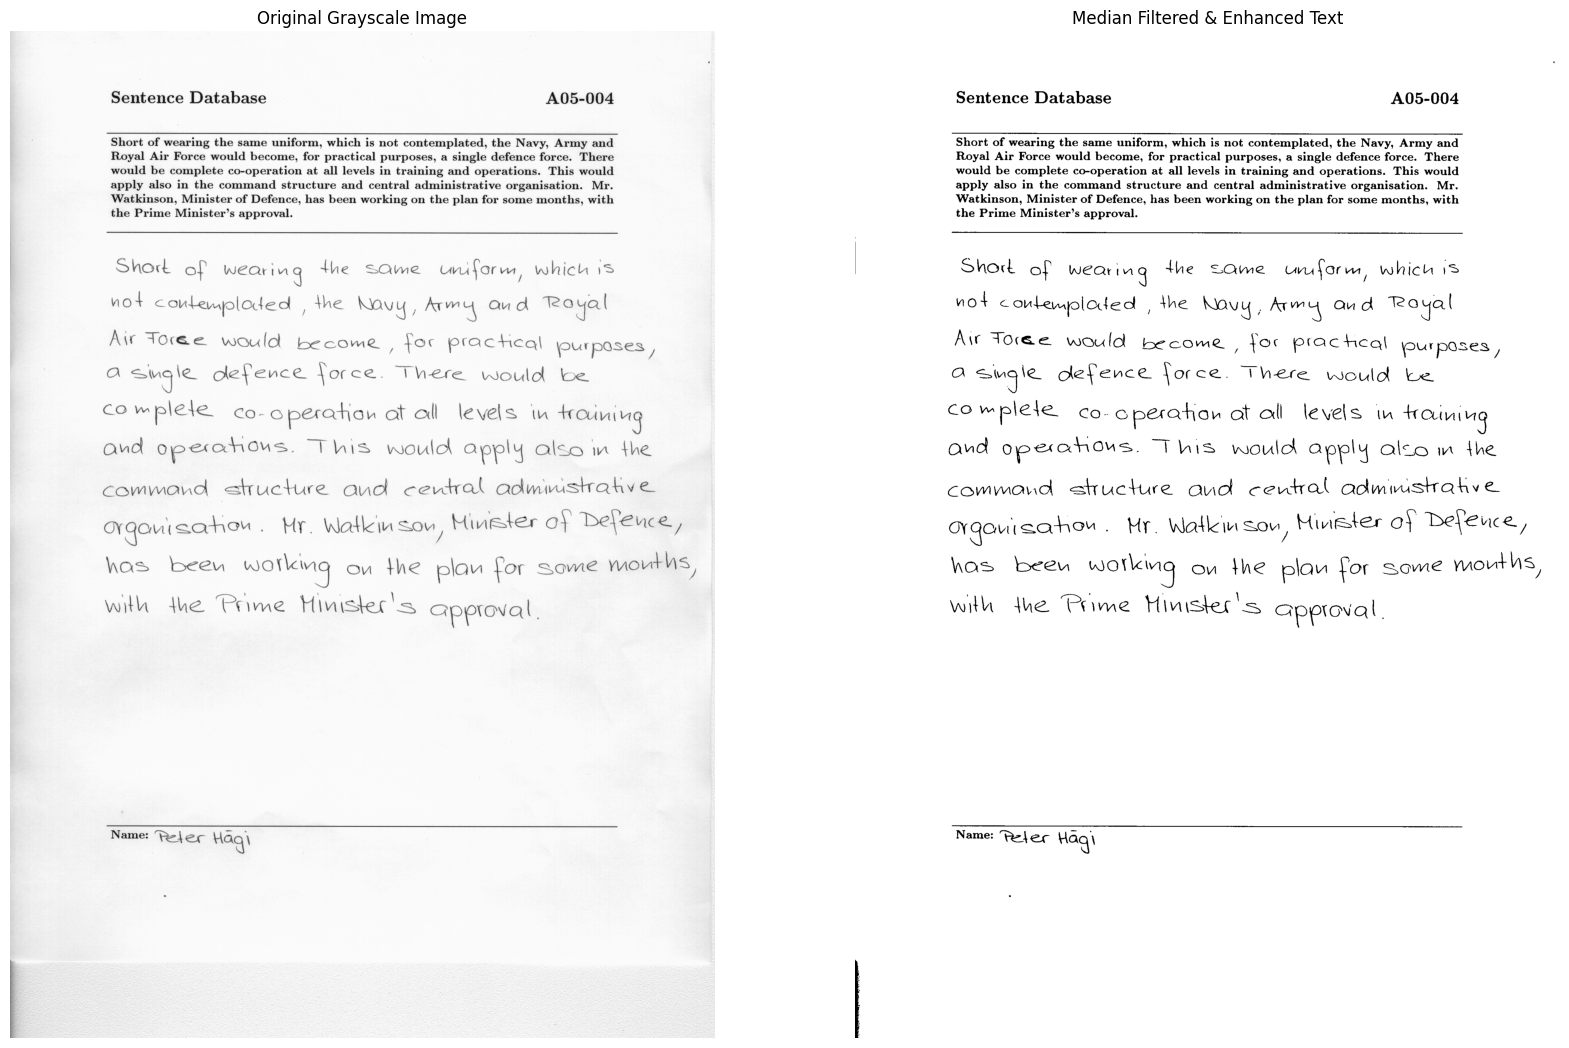

Filtered and enhanced image saved at: a05-004_filtered.png


In [1]:
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import median
from skimage.morphology import square
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
import numpy as np
import cv2
def median_filter(img, kernel_size=3):

  # Check if the image is already grayscale
  if len(img.shape) == 2:
      print("Image is already grayscale.")
      gray_img = img  # If already grayscale, no need to convert
  else:
      print("Image is RGB, converting to grayscale.")
      gray_img = rgb2gray(img)  # Convert to grayscale if it's RGB

  # Step 2: Apply median filtering to reduce noise
  # Use a square mask of 3x3 size for median filtering (adjust size as needed)
  median_filtered_image = median(gray_img, square(3))

  # Step 3: Thresholding to highlight the text clearly
  # Using Otsu's method to find an optimal threshold
  threshold_value = threshold_otsu(median_filtered_image)
  binary_image = median_filtered_image > threshold_value

  # Step 4: Enhance contrast (scaling pixel values for better display)
  contrast_image = np.uint8(binary_image * 255)

  return contrast_image

img_path = "a05-004.png"
filtered_image = median_filter(cv2.imread(img_path))

# Step 5: Save the filtered and enhanced image
output_path = 'a05-004_filtered.png'
cv2.imwrite(output_path, filtered_image)

# Display the results
plt.figure(figsize=(20,20))

# Display the original and median filtered images
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(cv2.imread(img_path), cmap="gray")
plt.title("Original Grayscale Image")

plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(filtered_image, cmap="gray")
plt.title("Median Filtered & Enhanced Text")

plt.show()

print(f"Filtered and enhanced image saved at: {output_path}")

Image is RGB, converting to grayscale.


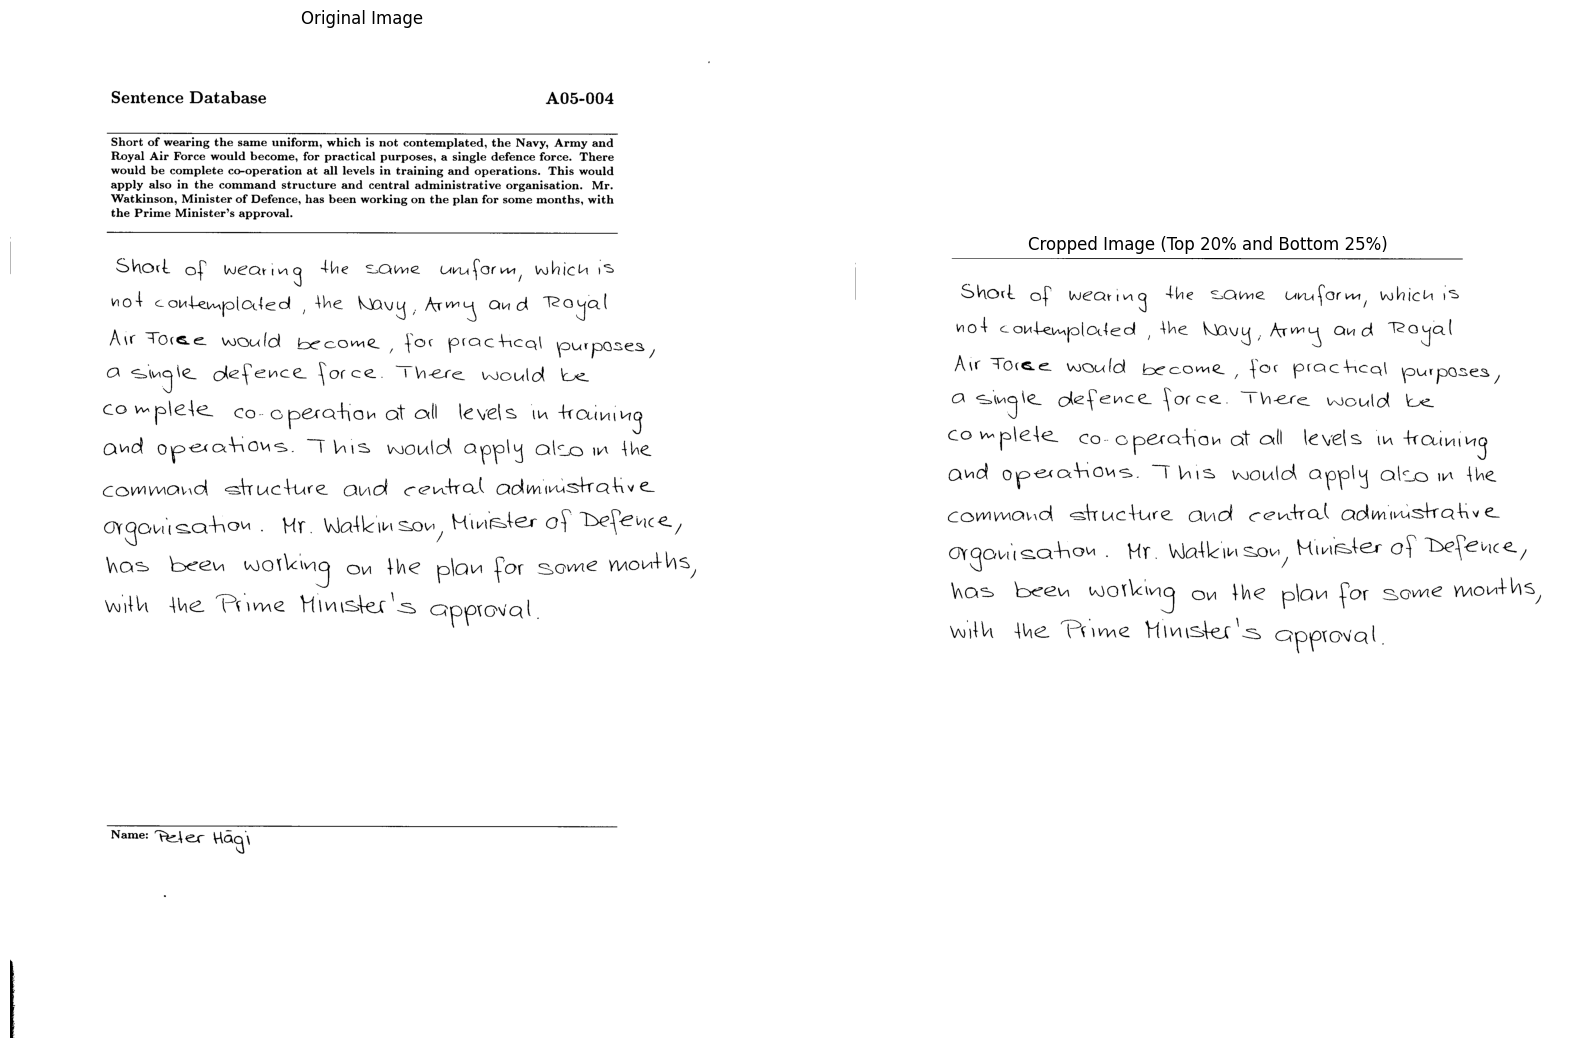

Cropped image saved at: /content/a02-000_cropped.png


In [2]:
import cv2
import matplotlib.pyplot as plt

def crop_image(img, top_crop_percentage=0.20, bottom_crop_percentage=0.25):

  if len(img.shape) == 2:
      print("Image is already grayscale.")
      img = img  # If already grayscale, no need to convert
  else:
      print("Image is RGB, converting to grayscale.")
      img = rgb2gray(img)  # Convert to grayscale if it's RGB

  # Step 2: Calculate the crop boundaries based on percentages
  height, width = img.shape

  # Top crop: 20% from the top
  top_crop = int(top_crop_percentage * height)

  # Bottom crop: 10% from the bottom
  bottom_crop = int(bottom_crop_percentage * height)

  # Crop the image
  cropped_image = img[top_crop:height - bottom_crop, :]

  return cropped_image

img = cv2.imread('a05-004_filtered.png')
cropped_image = crop_image(img)

# Step 3: Save the cropped image for further processing
output_path = '/content/a02-000_cropped.png'
cv2.imwrite(output_path, cropped_image)

# Step 4: Display the original and cropped images
plt.figure(figsize=(20,25))

# Display the original image
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(img, cmap="gray")
plt.title("Original Image")

# Display the cropped image
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(cropped_image, cmap="gray")
plt.title("Cropped Image (Top 20% and Bottom 25%)")

plt.show()

print(f"Cropped image saved at: {output_path}")


## Detect

In [3]:
from collections import defaultdict
from dataclasses import dataclass
from typing import List
import cv2
import numpy as np
from sklearn.cluster import DBSCAN


@dataclass
class BBox:
    x: int
    y: int
    w: int
    h: int


@dataclass
class DetectorRes:
    img: np.ndarray
    bbox: BBox


def detect(img: np.ndarray,
           kernel_size: int,
           sigma: float,
           theta: float,
           min_area: int) -> List[DetectorRes]:
    """Scale space technique for word segmentation proposed by R. Manmatha.

    For details see paper http://ciir.cs.umass.edu/pubfiles/mm-27.pdf.

    Args:
        img: A grayscale uint8 image.
        kernel_size: The size of the filter kernel, must be an odd integer.
        sigma: Standard deviation of Gaussian function used for filter kernel.
        theta: Approximated width/height ratio of words, filter function is distorted by this factor.
        min_area: Ignore word candidates smaller than specified area.

    Returns:
        List of DetectorRes instances, each containing the bounding box and the word image.
    """
    assert img.ndim == 2
    assert img.dtype == np.uint8

    # apply filter kernel
    kernel = _compute_kernel(kernel_size, sigma, theta)
    img_filtered = cv2.filter2D(img, -1, kernel, borderType=cv2.BORDER_REPLICATE).astype(np.uint8)
    img_thres = 255 - cv2.threshold(img_filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # append components to result
    res = []
    components = cv2.findContours(img_thres, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
    for c in components:
        # skip small word candidates
        if cv2.contourArea(c) < min_area:
            continue
        # append bounding box and image of word to result list
        x, y, w, h = cv2.boundingRect(c)  # bounding box as tuple (x, y, w, h)
        crop = img[y:y + h, x:x + w]
        res.append(DetectorRes(crop, BBox(x, y, w, h)))

    return res


def _compute_kernel(kernel_size: int,
                    sigma: float,
                    theta: float) -> np.ndarray:
    """Compute anisotropic filter kernel."""

    assert kernel_size % 2  # must be odd size

    # create coordinate grid
    half_size = kernel_size // 2
    xs = ys = np.linspace(-half_size, half_size, kernel_size)
    x, y = np.meshgrid(xs, ys)

    # compute sigma values in x and y direction, where theta is roughly the average x/y ratio of words
    sigma_y = sigma
    sigma_x = sigma_y * theta

    # compute terms and combine them
    exp_term = np.exp(-x ** 2 / (2 * sigma_x) - y ** 2 / (2 * sigma_y))
    x_term = (x ** 2 - sigma_x ** 2) / (2 * np.math.pi * sigma_x ** 5 * sigma_y)
    y_term = (y ** 2 - sigma_y ** 2) / (2 * np.math.pi * sigma_y ** 5 * sigma_x)
    kernel = (x_term + y_term) * exp_term

    # normalize and return kernel
    kernel = kernel / np.sum(kernel)
    return kernel


def prepare_img(img: np.ndarray,
                height: int) -> np.ndarray:
    """Convert image to grayscale image (if needed) and resize to given height."""
    assert img.ndim in (2, 3)
    assert height > 0
    assert img.dtype == np.uint8
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h = img.shape[0]
    factor = height / h
    return cv2.resize(img, dsize=None, fx=factor, fy=factor)


def _cluster_lines(detections: List[DetectorRes],
                   max_dist: float = 0.7,
                   min_words_per_line: int = 2) -> List[List[DetectorRes]]:
    # compute matrix containing Jaccard distances (which is a proper metric)
    num_bboxes = len(detections)
    dist_mat = np.ones((num_bboxes, num_bboxes))
    for i in range(num_bboxes):
        for j in range(i, num_bboxes):
            a = detections[i].bbox
            b = detections[j].bbox
            if a.y > b.y + b.h or b.y > a.y + a.h:
                continue
            intersection = min(a.y + a.h, b.y + b.h) - max(a.y, b.y)
            union = a.h + b.h - intersection
            iou = np.clip(intersection / union if union > 0 else 0, 0, 1)
            dist_mat[i, j] = dist_mat[j, i] = 1 - iou  # Jaccard distance is defined as 1-iou

    dbscan = DBSCAN(eps=max_dist, min_samples=min_words_per_line, metric='precomputed').fit(dist_mat)

    clustered = defaultdict(list)
    for i, cluster_id in enumerate(dbscan.labels_):
        if cluster_id == -1:
            continue
        clustered[cluster_id].append(detections[i])

    res = sorted(clustered.values(), key=lambda line: [det.bbox.y + det.bbox.h / 2 for det in line])
    return res


def sort_multiline(detections: List[DetectorRes],
                   max_dist: float = 0.7,
                   min_words_per_line: int = 2) -> List[List[DetectorRes]]:
    """Cluster detections into lines, then sort the lines according to x-coordinates of word centers.

    Args:
        detections: List of detections.
        max_dist: Maximum Jaccard distance (0..1) between two y-projected words to be considered as neighbors.
        min_words_per_line: If a line contains less words than specified, it is ignored.

    Returns:
        List of lines, each line itself a list of detections.
    """
    lines = _cluster_lines(detections, max_dist, min_words_per_line)
    res = []
    for line in lines:
        res += sort_line(line)
    return res


def sort_line(detections: List[DetectorRes]) -> List[List[DetectorRes]]:
    """Sort the list of detections according to x-coordinates of word centers."""
    return [sorted(detections, key=lambda det: det.bbox.x + det.bbox.w / 2)]


Image is RGB, converting to grayscale.


<ipython-input-1-77be575cb3cd>:21: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  median_filtered_image = median(gray_img, square(3))


Image is already grayscale.
0 15 7 62
188 46 103 30
312 49 44 34
381 59 152 40
557 52 57 24
638 56 104 21
772 47 146 33
943 55 105 25
1060 56 34 19
176 110 69 27
259 117 254 34
546 115 56 25
621 117 102 42
746 118 99 44
860 119 81 24
960 112 121 49
177 176 52 27
243 177 112 29
378 184 116 26
513 191 156 23
708 182 56 31
783 189 90 25
875 188 86 24
980 196 173 30
172 242 32 21
214 243 124 48
363 236 174 34
552 234 112 39
697 239 125 30
847 243 124 28
988 249 59 22
163 305 205 40
401 315 50 23
465 308 200 46
675 313 42 28
725 310 51 29
804 311 115 29
940 321 34 17
986 313 162 53
166 371 81 33
262 370 245 47
534 370 36 24
579 377 76 24
676 373 125 30
817 377 114 41
946 379 56 25
988 385 51 22
1048 386 35 18
1099 378 61 28
164 448 199 31
383 447 191 29
600 447 88 31
707 443 149 32
874 444 290 31
166 515 273 53
485 515 51 28
563 511 207 34
790 508 163 28
963 499 47 38
1027 499 187 43
169 587 86 29
284 588 108 27
418 581 167 62
604 598 53 21
675 589 70 28
763 590 94 42
868 584 62 45
949 591 

<ipython-input-4-ccc1709bbe01>:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('rainbow', num_colors)


169 656 84 31
284 659 69 29
372 651 127 36
517 655 164 35
699 666 38 24
755 666 187 45


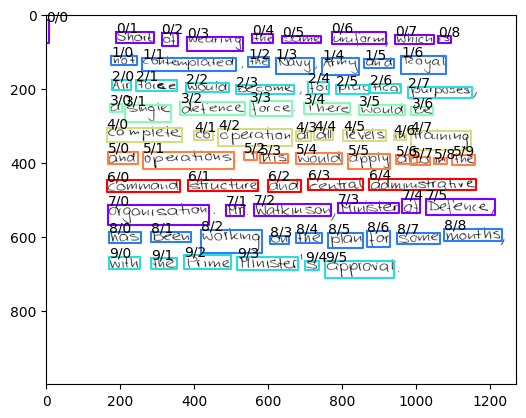

In [4]:
import os

kernel_size = 25
sigma=11
theta=7
min_area=100
img_height=1000

filtered_image = median_filter(cv2.imread(img_path))
cropped_image = crop_image(filtered_image)
img = prepare_img(cropped_image, img_height)
detections = detect(img,
                    kernel_size=kernel_size,
                    sigma=sigma,
                    theta=theta,
                    min_area=min_area)

# sort detections: cluster into lines, then sort each line
lines = sort_multiline(detections)

# plot results
plt.imshow(img, cmap='gray')
num_colors = 7
colors = plt.cm.get_cmap('rainbow', num_colors)
for line_idx, line in enumerate(lines):
    for word_idx, det in enumerate(line):
        xs = [det.bbox.x, det.bbox.x, det.bbox.x +
                det.bbox.w, det.bbox.x + det.bbox.w, det.bbox.x]
        ys = [det.bbox.y, det.bbox.y + det.bbox.h,
                det.bbox.y + det.bbox.h, det.bbox.y, det.bbox.y]
        plt.plot(xs, ys, c=colors(line_idx % num_colors))
        plt.text(det.bbox.x, det.bbox.y, f'{line_idx}/{word_idx}')
        print(det.bbox.x, det.bbox.y, det.bbox.w, det.bbox.h)
        crop_img = img[det.bbox.y:det.bbox.y +
                        det.bbox.h, det.bbox.x:det.bbox.x+det.bbox.w]

        path = './test_imgs'
        # Check whether the specified
        # path exists or not
        isExist = os.path.exists(path)
        if isExist == False:
            os.mkdir(path)
            print("Directory Created")

        cv2.imwrite(f"{path}/line" + str(line_idx) + "word" +
                            str(word_idx) + ".jpg", crop_img)

# **OCR**
## **Data Collection**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
!wget -q https://git.io/J0fjL -O IAM_Words.zip

!unzip -qq IAM_Words.zip

!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

In [6]:
!head -20 data/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE


In [5]:
from tensorflow.keras.layers import StringLookup
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf

import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

# **Dataset Splitting**

In [6]:
base_path = "/content/data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
  if line[0] =="#":
    continue
  if line.split(" ")[1] != "err":
    words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

In [7]:
print(words_list[0:10])
# base_path = "/content/data"

['e04-030-04-08 ok 170 1489 1499 120 39 JJ sure\n', 'k02-102-05-03 ok 182 836 1623 69 52 PP3A he\n', 'a01-082u-01-04 ok 172 1582 1043 234 88 IN during\n', 'm01-000-07-00 ok 196 339 1998 75 107 INO of\n', 'g01-031-07-06 ok 152 1912 2038 167 59 NN booty\n', 'f07-081b-01-06 ok 168 1366 924 350 88 NN gastronomy\n', 'n03-082-04-03 ok 165 992 1414 118 135 NN boy\n', 'g06-018c-04-05 ok 182 1298 1438 96 58 ATI The\n', 'g06-011j-06-06 ok 182 1222 1785 146 95 CC and\n', 'f04-024-01-06 ok 183 1104 981 60 70 IN in\n']


In [8]:
# We will split the dataset into three subsets with a 90:5:5 ratio (train:validation:test)

In [9]:
split_idx = int(0.9*len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(test_samples)

print(f"Total Training Samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")


Total Training Samples: 86810
Total validation samples: 4823
Total test samples: 4823


# **Data input pipeline**

We start builind our data inpuit pipeline by first preparing the image paths

In [10]:
base_image_path = os.path.join(base_path, "words")
print(base_path)
def get_image_paths_and_labels(samples):
  paths = []
  corrected_samples = []
  for (i, file_line) in enumerate(samples):
    line_split = file_line.strip()
    line_split = line_split.split(" ")

    # Each line split willl have this format for the the corresponding image:
    # part1/part1-part2/part1-part2-part3.png
    image_name = line_split[0]
    partI = image_name.split("-")[0]
    partII = image_name.split("-")[1]
    img_path = os.path.join(
        base_image_path, partI, partI + "-" + partII, image_name + ".png"
    )
    if os.path.getsize(img_path):
      paths.append(img_path)
      corrected_samples.append(file_line.split("\n")[0])

  return paths, corrected_samples

train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)


/content/data


In [11]:
train_img_paths[0:5]

['/content/data/words/e04/e04-030/e04-030-04-08.png',
 '/content/data/words/k02/k02-102/k02-102-05-03.png',
 '/content/data/words/a01/a01-082u/a01-082u-01-04.png',
 '/content/data/words/m01/m01-000/m01-000-07-00.png',
 '/content/data/words/g01/g01-031/g01-031-07-06.png']

In [12]:
train_labels[0:5]

['e04-030-04-08 ok 170 1489 1499 120 39 JJ sure',
 'k02-102-05-03 ok 182 836 1623 69 52 PP3A he',
 'a01-082u-01-04 ok 172 1582 1043 234 88 IN during',
 'm01-000-07-00 ok 196 339 1998 75 107 INO of',
 'g01-031-07-06 ok 152 1912 2038 167 59 NN booty']

# **Testing Data input Pipeline**

In [13]:
base_image_path = "test_imgs"
print(base_image_path)

t_images = []
from os import listdir
from os.path import isfile, join

# onlyfiles = [f for f in listdir(base_image_path) if isfile(join(base_image_path, f))]
for f in listdir(base_image_path):
  t_images_path = os.path.join(base_image_path, f)
  t_images.append(t_images_path)

print(t_images)

test_imgs
['test_imgs/line5word8.jpg', 'test_imgs/line4word2.jpg', 'test_imgs/line5word7.jpg', 'test_imgs/line3word3.jpg', 'test_imgs/line1word4.jpg', 'test_imgs/line2word0.jpg', 'test_imgs/line3word6.jpg', 'test_imgs/line9word3.jpg', 'test_imgs/line8word1.jpg', 'test_imgs/line2word7.jpg', 'test_imgs/line8word0.jpg', 'test_imgs/line0word8.jpg', 'test_imgs/line8word3.jpg', 'test_imgs/line7word4.jpg', 'test_imgs/line1word5.jpg', 'test_imgs/line1word0.jpg', 'test_imgs/line6word0.jpg', 'test_imgs/line6word2.jpg', 'test_imgs/line4word0.jpg', 'test_imgs/line2word6.jpg', 'test_imgs/line8word6.jpg', 'test_imgs/line9word1.jpg', 'test_imgs/line0word7.jpg', 'test_imgs/line8word8.jpg', 'test_imgs/line5word3.jpg', 'test_imgs/line5word9.jpg', 'test_imgs/line4word6.jpg', 'test_imgs/line7word0.jpg', 'test_imgs/line4word4.jpg', 'test_imgs/line2word3.jpg', 'test_imgs/line7word3.jpg', 'test_imgs/line0word4.jpg', 'test_imgs/line5word4.jpg', 'test_imgs/line1word6.jpg', 'test_imgs/line2word2.jpg', 'test_img

In [14]:
t_images[0:10]

['test_imgs/line5word8.jpg',
 'test_imgs/line4word2.jpg',
 'test_imgs/line5word7.jpg',
 'test_imgs/line3word3.jpg',
 'test_imgs/line1word4.jpg',
 'test_imgs/line2word0.jpg',
 'test_imgs/line3word6.jpg',
 'test_imgs/line9word3.jpg',
 'test_imgs/line8word1.jpg',
 'test_imgs/line2word7.jpg']

In [15]:
# Sorting string list with numbers

import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

# alist=[
#     "something1",
#     "something12",
#     "something17",
#     "something2",
#     "something25",
#     "something29"]

t_images.sort(key=natural_keys)
print(t_images)

['test_imgs/line0word0.jpg', 'test_imgs/line0word1.jpg', 'test_imgs/line0word2.jpg', 'test_imgs/line0word3.jpg', 'test_imgs/line0word4.jpg', 'test_imgs/line0word5.jpg', 'test_imgs/line0word6.jpg', 'test_imgs/line0word7.jpg', 'test_imgs/line0word8.jpg', 'test_imgs/line1word0.jpg', 'test_imgs/line1word1.jpg', 'test_imgs/line1word2.jpg', 'test_imgs/line1word3.jpg', 'test_imgs/line1word4.jpg', 'test_imgs/line1word5.jpg', 'test_imgs/line1word6.jpg', 'test_imgs/line2word0.jpg', 'test_imgs/line2word1.jpg', 'test_imgs/line2word2.jpg', 'test_imgs/line2word3.jpg', 'test_imgs/line2word4.jpg', 'test_imgs/line2word5.jpg', 'test_imgs/line2word6.jpg', 'test_imgs/line2word7.jpg', 'test_imgs/line3word0.jpg', 'test_imgs/line3word1.jpg', 'test_imgs/line3word2.jpg', 'test_imgs/line3word3.jpg', 'test_imgs/line3word4.jpg', 'test_imgs/line3word5.jpg', 'test_imgs/line3word6.jpg', 'test_imgs/line4word0.jpg', 'test_imgs/line4word1.jpg', 'test_imgs/line4word2.jpg', 'test_imgs/line4word3.jpg', 'test_imgs/line4wor

Then we prepare the groung-truth labels

In [16]:
# find maximum length and the size of the vocabulary in the training data.

train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
  label = label.split(" ")[-1].strip()
  for char in label:
    characters.add(char)

  max_len = max(max_len, len(label))
  train_labels_cleaned.append(label)

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples
train_labels_cleaned[:10]

Maximum length:  21
Vocab size:  78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

Now we clean the validation and the test labels as well

In [17]:
def clean_labels(labels):
  cleaned_labels = []
  for label in labels:
    label = label.split(" ")[-1].strip()
    cleaned_labels.append(label)
  return cleaned_labels

validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)


In [18]:
ff = list(characters)

In [19]:
import pickle
with open("/content/characters", "wb") as fp:   #Pickling
    pickle.dump(ff, fp)

In [20]:
import pickle
with open("/content/characters", "rb") as fp:   # Unpickling
    b = pickle.load(fp)
    print(b)

['L', 'E', '"', '0', '2', 's', 'l', 'w', 'p', 'P', 'H', '/', 'O', 'V', 'f', '!', 'X', 'v', 'M', ':', 'N', '4', '3', "'", 'F', 'J', '(', 'K', '+', 'o', '#', 'I', 'r', '9', ',', '&', '8', 'B', '*', 'Q', 'g', '.', 'W', 'j', 'q', 'm', 'c', '5', ';', '7', 'U', 'h', 'u', 'a', ')', 'R', 'i', 'C', 'z', 'n', '-', 'Y', 'D', 'x', 'd', 'S', 'y', 'Z', 'e', 'k', 'G', '?', 'T', 'A', '6', 't', '1', 'b']


**Building the character vocabulary**

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

# Maping characaters to integers
char_to_num = StringLookup(vocabulary=b, mask_token=None)

#Maping integers back to original characters
num_to_chars = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)


- Resizing images without distortion

Instead of square images, many OCR models work with rectangular images. This will become clearer in a moment when we will visualize a few
‘samples from the dataset. While aspect-unaware resizing square images does not introduce a significant amount of distortion this is not the
case for rectangular images. But resizing images to a uniform size is a requirement for mini-batching. So we need to perform our resizing such
that the following criteria are met:

+ Aspect ratio is preserved.

+ Content of the images is not affected.



In [22]:
def distortion_free_resize(image, img_size):
  w, h = img_size
  image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

  # Check tha amount of padding needed to be done.
  pad_height = h - tf.shape(image)[0]
  pad_width = w - tf.shape(image)[1]

  # only necessary if you want to do same amount of padding on both sides.
  if pad_height % 2 != 0:
    height = pad_height // 2
    pad_height_top = height +1
    pad_height_bottom = height
  else:
    pad_height_top = pad_height_bottom = pad_height // 2

  if pad_width % 2 != 0:
    width = pad_width // 2
    pad_width_left = width + 1
    pad_width_right = width
  else:
    pad_width_left = pad_width_right = pad_width // 2

  image = tf.pad(
      image, paddings=[
          [pad_height_top, pad_height_bottom],
          [pad_width_left, pad_width_right],
          [0, 0],
      ],
  )
  image = tf.transpose(image, perm=[1,0,2])
  image = tf.image.flip_left_right(image)
  return image


# if we just go witht the plain resizing then the images would look like so:

# putting the utilities together

In [23]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

def preprocess_image(image_path, img_size=(image_width, image_height)):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image, 1)
  image = distortion_free_resize(image, img_size)
  image = tf.cast(image, tf.float32) / 255.0
  return image

def vectorize_label(label):
  label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
  length = tf.shape(label)[0]
  pad_amount = max_len - length
  label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
  return label


def process_images_labels(image_path, label):
  image = preprocess_image(image_path)
  label = vectorize_label(label)
  return {"image": image, "label": label}

def prepare_dataset(image_paths, labels):
  dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
    process_images_labels, num_parallel_calls=AUTOTUNE
  )

  return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


Prepare tf.data.Dataset objects

In [24]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)


## Preparing new inference/testing images

In [25]:
# Testing inference images
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

def preprocess_image(image_path, img_size=(image_width, image_height)):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image, 1)
  image = distortion_free_resize(image, img_size)
  image = tf.cast(image, tf.float32) / 255.0
  return image

def process_images_2(image_path):
  image = preprocess_image(image_path)
  # label = vectorize_label(label)
  return {"image": image}

def prepare_test_images(image_paths):
  dataset = tf.data.Dataset.from_tensor_slices((image_paths)).map(
    process_images_2, num_parallel_calls=AUTOTUNE
  )

  # return dataset
  return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

inf_images = prepare_test_images(t_images)

## Visualize new test images

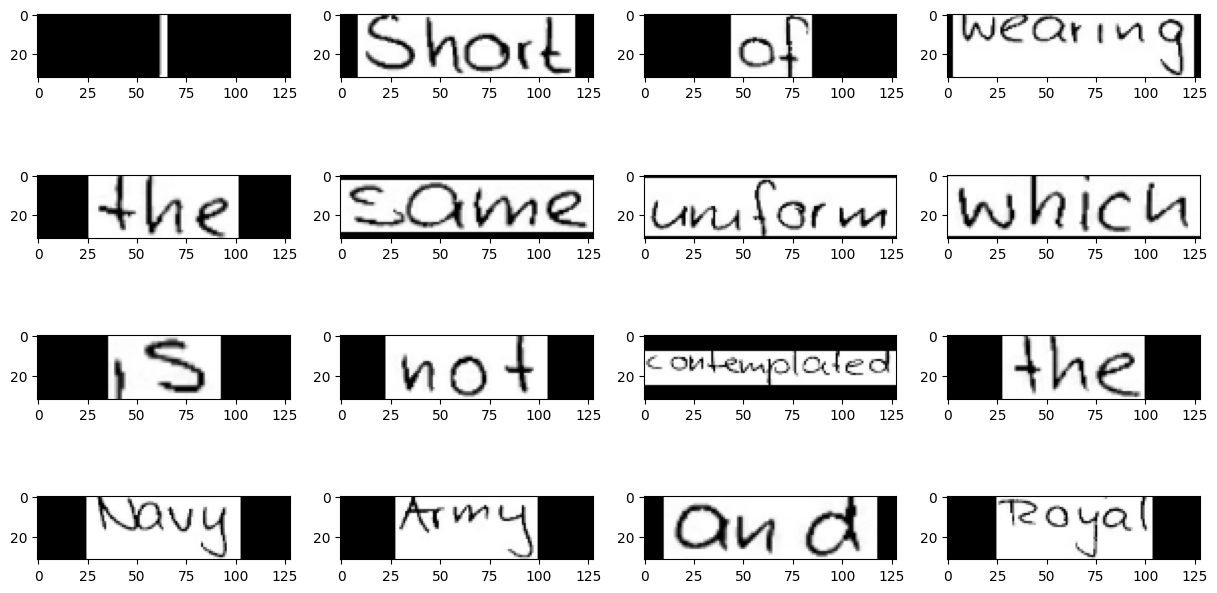

In [26]:
# Visualize test images

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

for data in inf_images.take(1):
  images = data["image"]
  # imm = images.reshape(images.shape[0], (images.shape[1]*images.shape[2]))
  # imm = imm.transpose()
  # print(imm.shape)
  _, ax = plt.subplots(4, 4, figsize=(15, 8))

  # ss = plt.imshow(imm, cmap="gray")
  # plt.show()
  for i in range(16):
    img = images[i]
    # print(img.shape)
    img = tf.image.flip_left_right(img)
    img = tf.transpose(img, perm=[1, 0, 2])
    img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
    img = img[:, :, 0]

    # Gather indices where Label!= padding token

    ax[i // 4, i % 4].imshow(img, cmap="gray")


  plt.show()


Visualize few samples

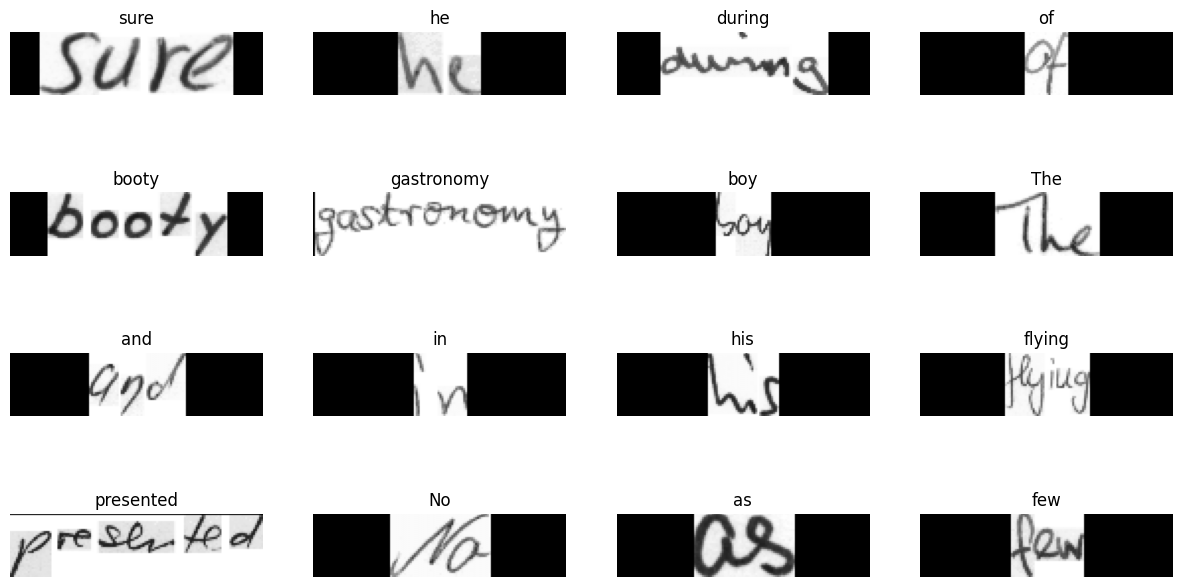

In [27]:
for data in train_ds.take(1):
  images, labels = data["image"], data["label"]
  _, ax = plt.subplots(4, 4, figsize=(15, 8))

  for i in range(16):
    img = images[i]
    # print(img.shape)
    img = tf.image.flip_left_right(img)
    img = tf.transpose(img, perm=[1, 0, 2])
    img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
    img = img[:, :, 0]

    # Gather indices where Label!= padding token
    label = labels[i]
    indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
    # Convert to string.
    label = tf.strings.reduce_join(num_to_chars(indices))
    label = label.numpy().decode("utf-8")

    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(label)
    ax[i // 4, i % 4].axis("off")

  plt.show()


# **Model**

Model uses CTC loss as an endpoint layer.

In [28]:
class CTCLayer(keras.layers.Layer):

  def __init__(self, name=None):
    super().__init__(name=name)
    self.loss_fn = keras.backend.ctc_batch_cost

  def call(self, y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    loss = self.loss_fn(y_true, y_pred, input_length, label_length)
    self.add_loss(loss)

    # At test time, just return the computed predictions.
    return y_pred

def build_model():
  input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
  labels = keras.layers.Input(name="label", shape=(None,))

  # first conv block
  x = keras.layers.Conv2D(
      32, (3,3), activation = "relu",
      kernel_initializer="he_normal",
      padding="same",
      name="Conv1"
  )(input_img)
  x = keras.layers.MaxPooling2D((2,2), name="pool1")(x)

  # Second conv block
  x = keras.layers.Conv2D(
      64, (3,3), activation = "relu", kernel_initializer="he_normal",
      padding="same",
      name="Conv2"
  )(x)
  x = keras.layers.MaxPooling2D((2,2), name="pool2")(x)

  # We have two maxpool layers with pool size and strides 2
  # Hence downsampled feature maps are 4x smaller the number of filters in the last layer is 64,
  # Reshape accordingly before passing the output to the RNN part of the model.

  new_shape = ((image_width // 4), (image_height // 4) * 64)
  x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
  x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
  x = keras.layers.Dropout(0.2)(x)

  # RNN
  x = keras.layers.Bidirectional(
      keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
  )(x)
  x = keras.layers.Bidirectional(
    keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
  )(x)
  # +2 is to account for the two special tokens introduced by the CTC loss.
  # The recommendation comes here: https://git.10/J0eXP.
  x = keras.layers.Dense(
    len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
  )(x)
  # Add CTC layer for calculating CTC Loss at each step.
  output = CTCLayer(name="ctc_loss")(labels, x)

  # Define the model.
  model = keras.models.Model(
      inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
  )

  # optimizer
  opt = keras.optimizers.Adam()
  # Compile the model and return
  model.compile(optimizer=opt)
  return model

# Get the model
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['pool1[0][0

# **Evaluation Matrix**

In [29]:
# Edit Distance is the most widely used metric for evaluating OCR models. In this section, we will implement it and use it as a callback to monitor
# ‘our model.

# We first segregate the validation images and their labels for convenience.

validation_images = []
validation_labels = []

for batch in validation_ds:
  validation_images.append(batch["image"])
  validation_labels.append(batch["label"])



Now we create a callback to monitor the edit distance

In [30]:
def calculate_edit_distance(labels, predictions):
  # Get a single batch and convert its labels to sparse tensors.
  sparse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

  # Make predictions and convert them to sparse tensors.
  input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
  predictions_decoded = keras.backend.ctc_decode(
    predictions, input_length=input_len, greedy=True
  )[0][0][:, :max_len]
  sparse_predictions = tf.cast(
    tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
  )

  # Compute individual edit distances and average them out.
  edit_distances = tf.edit_distance(
    sparse_predictions, sparse_labels, normalize=False
  )
  return tf.reduce_mean(edit_distances)

class EditDistanceCallback(keras.callbacks.Callback):
  def __init__(self, pred_model):
    super().__init__()
    self.prediction_model = pred_model
  def on_epoch_end(self, epoch, logs = None):
    edit_distances = []

    for i in range(len(validation_images)):
      labels = validation_labels[i]
      predictions = self.prediction_model.predict(validation_images[i])
      edit_distances.append(calculate_edit_distance(labels, predictions).numpy())
    print(f"Mean eidt distance for each {epoch + 1}: {np.mean(edit_distances): .4f}")



# **Training**

In [ ]:
# Now we are ready to kick off model training,

epochs = 50 # To get good results this should be at least 50.

model = build_model()
prediction_model = keras.models.Model(
  model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs,
  callbacks=[edit_distance_callback],
)

Epoch 1/50
1/1 [==============================] - 1s 1s/step
Mean eidt distance for each 1:  20.4689
1357/1357 [==============================] - 144s 96ms/step - loss: 13.6432 - val_loss: 11.8632
Epoch 2/50
1/1 [==============================] - 0s 23ms/step
Mean eidt distance for each 2:  20.0768
1357/1357 [==============================] - 75s 55ms/step - loss: 10.7012 - val_loss: 9.7497
Epoch 3/50
1/1 [==============================] - 0s 22ms/step
Mean eidt distance for each 3:  19.7033
1357/1357 [==============================] - 75s 56ms/step - loss: 9.0221 - val_loss: 7.9626
Epoch 4/50
1/1 [==============================] - 0s 20ms/step
Mean eidt distance for each 4:  19.0678
1357/1357 [==============================] - 74s 55ms/step - loss: 7.5254 - val_loss: 6.3341
Epoch 5/50
1/1 [==============================] - 0s 23ms/step
Mean eidt distance for each 5:  18.6523
1357/1357 [==============================] - 75s 55ms/step - loss: 6.3174 - val_loss: 5.2139
Epoch 6/50
1/1 [==

In [ ]:
history

{'loss': [13.6432,
  10.7012,
  9.0221,
  7.5254,
  6.3174,
  5.3875,
  4.6919,
  4.1963,
  3.8538,
  3.5853,
  3.3795,
  3.2221,
  3.0721,
  2.9332,
  2.8115,
  2.7036,
  2.6052,
  2.5134,
  2.4271,
  2.3453,
  2.2678,
  2.1946,
  2.1243,
  2.0571,
  2.0027,
  1.9548,
  1.9072,
  1.8615,
  1.8167,
  2.0542,
  2.0376,
  2.0211,
  2.0046,
  1.9881,
  1.9725,
  1.9573,
  1.9422,
  1.9271,
  1.9125,
  1.8983,
  1.8845,
  1.8709,
  1.8573,
  1.8438,
  1.8305,
  1.8173,
  1.8042,
  1.7912,
  1.7784,
  1.7257,
  1.6764,
  1.6617],
 'val_loss': [11.8632,
  9.7497,
  7.9626,
  6.3341,
  5.2139,
  4.3872,
  3.7193,
  3.2867,
  3.0474,
  2.896,
  2.7464,
  2.6543,
  2.5632,
  2.4756,
  2.3902,
  2.3075,
  2.2276,
  2.1503,
  2.0754,
  2.0028,
  1.9324,
  1.8639,
  1.7974,
  1.7329,
  1.6698,
  1.6087,
  1.5491,
  1.4912,
  1.4349,
  1.9081,
  1.9068,
  1.9055,
  1.9042,
  1.9029,
  1.9016,
  1.9003,
  1.899,
  1.8977,
  1.8964,
  1.8951,
  1.8938,
  1.8925,
  1.8912,
  1.8899,
  1.8886,
  1.8873

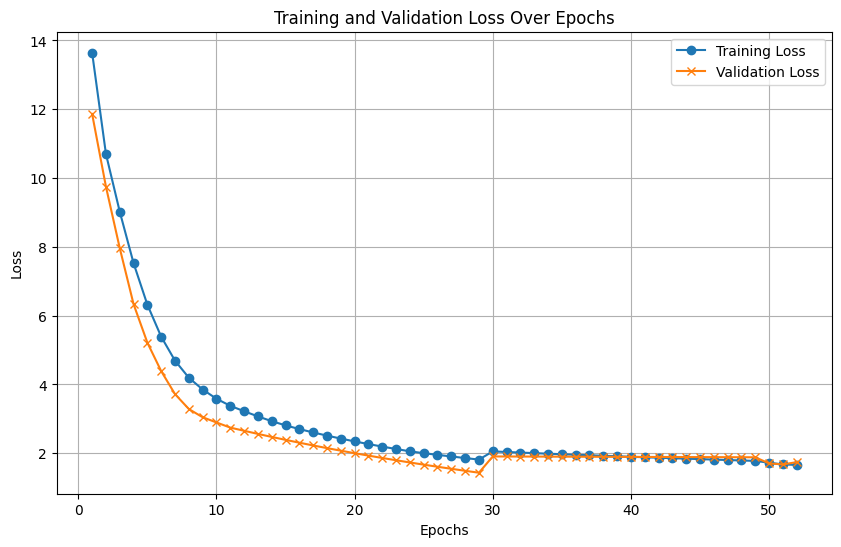

In [ ]:
import matplotlib.pyplot as plt
# Extract values for plotting
epochs = range(1, len(history["loss"]) + 1)
loss = history["loss"]
val_loss = history["val_loss"]

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label="Training Loss", marker='o')
plt.plot(epochs, val_loss, label="Validation Loss", marker='x')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Saving thje model

# model.save_weights('/content/drive/MyDrive/Colab Notebooks/OCR/ocr_model_v4.h5')
# prediction_model.save_weights('/content/drive/MyDrive/Colab Notebooks/OCR/ocr_model_v5.h5')

# Below is working saved models
# model.save("/content/drive/MyDrive/Colab Notebooks/OCR/ocr_model_v8.h5")
prediction_model.save("/content/drive/MyDrive/Colab Notebooks/OCR/ocr_model_50_epoch.h5")

# **Inferences**

(64, 128, 32, 1)
2/2 [==============================] - 2s 69ms/step


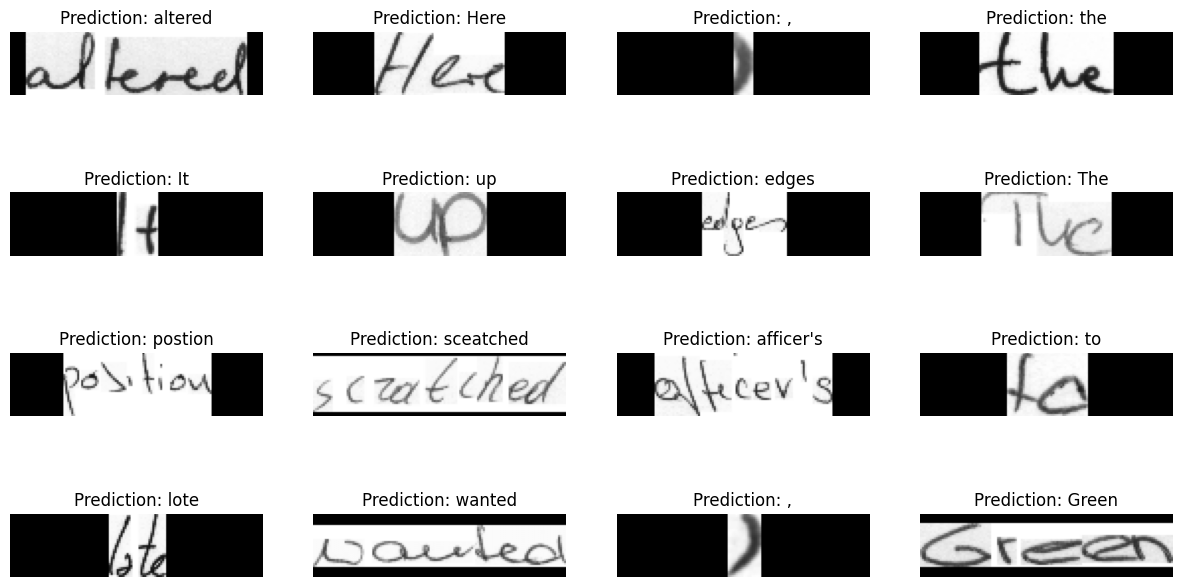

In [35]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]

    # Iterate over the results and get back the text.
    output_text = []

    for res in results:
      res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
      res = tf.strings.reduce_join(num_to_chars(res)).numpy().decode("utf-8")
      output_text.append(res)

    return output_text


# Let's check results on sone test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    print(batch_images.shape)

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
      img = batch_images[i]
      img = tf.image.flip_left_right(img)
      img = tf.transpose(img, perm=[1, 0, 2])
      img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
      img = img[:, :, 0]

      title = f"Prediction: {pred_texts[i]}"
      ax[i // 4, i % 4].imshow(img, cmap = "gray")
      ax[i // 4, i % 4].set_title(title)
      ax[i // 4, i % 4].axis("off")

    plt.show()


In [ ]:
# THE END

# Inference on New set of images

In [32]:
custom_objects = {"CTCLayer": CTCLayer}

In [33]:
reconstructed_model = keras.models.load_model("ocr_model_50_epoch.h5", custom_objects=custom_objects)

In [34]:
prediction_model = keras.models.Model(
  reconstructed_model.get_layer(name="image").input, reconstructed_model.get_layer(name="dense2").output
)

(64, 128, 32, 1)
2/2 [==============================] - 0s 75ms/step


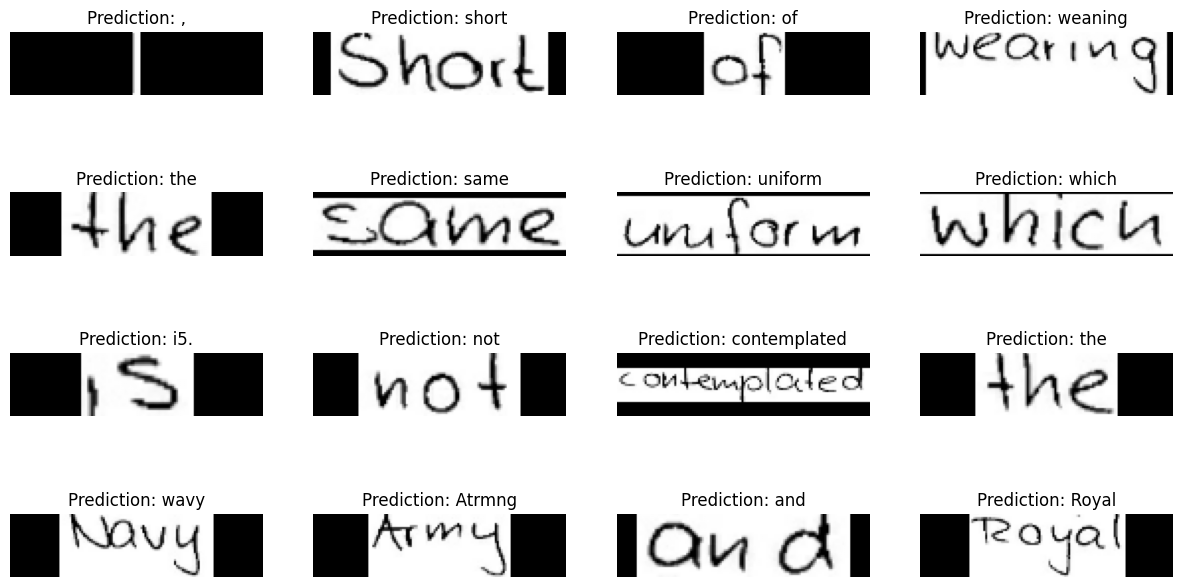

In [40]:
# Inference on New set of images
pred_test_text = []

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]

    # Iterate over the results and get back the text.
    output_text = []

    for res in results:
      res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
      res = tf.strings.reduce_join(num_to_chars(res)).numpy().decode("utf-8")
      output_text.append(res)

    return output_text


# Let's check results on sone test samples.
for batch in inf_images.take(1):
    batch_images = batch["image"]
    print(batch_images.shape)

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    pred_test_text.append(pred_texts)

    for i in range(16):
      img = batch_images[i]
      img = tf.image.flip_left_right(img)
      img = tf.transpose(img, perm=[1, 0, 2])
      img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
      img = img[:, :, 0]

      title = f"Prediction: {pred_texts[i]}"
      ax[i // 4, i % 4].imshow(img, cmap = "gray")
      ax[i // 4, i % 4].set_title(title)
      ax[i // 4, i % 4].axis("off")

    plt.show()


In [41]:
for batch in inf_images:
    batch_images = batch["image"]
    # batch_images= tf.expand_dims(batch_images, axis=0)
    print(batch_images.shape)

(64, 128, 32, 1)
(11, 128, 32, 1)


In [42]:
flat_list = [item for sublist in pred_test_text for item in sublist]
print(flat_list)

[',', 'short', 'of', 'weaning', 'the', 'same', 'uniform', 'which', 'i5.', 'not', 'contemplated', 'the', 'wavy', 'Atrmng', 'and', 'Royal', 'hir', 'Forse', 'would', 'become', 'for', 'pra', 'taal', 'purposes', 'a', 'single', 'defence', 'force', 'There', 'would', 'te', 'complete', 'S0.', 'operation', 'at', 'all', '1evels', 'i.', 'training', 'and', 'sperations', 'Ir', 'his', 'would', 'appry', 'ais', 'I', 'i.', 'the', 'command', 'structure', 'and', 'central', 'admmistratire', 'arganisation', 'Mr.', 'Watkinson', 'Minster', 'of', 'Defencey', 'has', 'been', 'working', 'bn']


In [43]:
sentence = ' '.join(flat_list)
print(sentence)

, short of weaning the same uniform which i5. not contemplated the wavy Atrmng and Royal hir Forse would become for pra taal purposes a single defence force There would te complete S0. operation at all 1evels i. training and sperations Ir his would appry ais I i. the command structure and central admmistratire arganisation Mr. Watkinson Minster of Defencey has been working bn


In [ ]:
!pip install gtts ipython


[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from gtts import gTTS
from IPython.display import Audio

# Convert text to speech
tts = gTTS(sentence, lang='en')
output_file = "output.mp3"
tts.save(output_file)

# Play the audio in the notebook
Audio(output_file, autoplay=True)
